# Fundamental Matrix Estimation, Camera Calibration, Triangulation (Python)
## Usage
This code snippet provides an overall code structure and some interactive plot interfaces for the Fundamental Matrix Estimation, Camera Calibration, Triangulation section of MP 3. We outline the required functionalities step by step. Feel free to make modifications on the starter code if it's necessary.

## Package installation
- You will need [GUI backend](https://matplotlib.org/faq/usage_faq.html#what-is-a-backend) to enable interactive plots in `matplotlib`.
- `numpy`
- `PIL`

In [96]:
######
#@title 1. Connect Colab to your google drive
######

%load_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount('/content/drive')
#### change to the directory in your drive. 
%cd "/content/drive/MyDrive/MP3/Q2"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/MP3/Q2


#### Common imports

In [97]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import skimage
import cv2
from scipy.spatial import distance
import scipy

#### Part (1)

In [98]:
def get_residual(F, p1, p2):
    """
    Function to compute the residual average residual on frame 2
    param: F (3x3): fundamental matrix: (pt in frame 2).T * F * (pt in frame 1) = 0
    param: p1 (Nx2): 2d points on frame 1
    param: p2 (Nx2): 2d points on frame 2
    """
    P1 = np.c_[p1, np.ones((p1.shape[0],1))].transpose()
    P2 = np.c_[p2, np.ones((p2.shape[0],1))].transpose()
    L2 = np.matmul(F, P1).transpose()
    L2_norm = np.sqrt(L2[:,0]**2 + L2[:,1]**2)
    L2 = L2 / L2_norm[:,np.newaxis]
    pt_line_dist = np.multiply(L2, P2.T).sum(axis = 1)
    return np.mean(np.square(pt_line_dist))

def plot_fundamental(ax, F, p1, p2, I):
    """
    Function to display epipolar lines and corresponding points
    param: F (3x3): fundamental matrix: (pt in frame 2).T * F * (pt in frame 1) = 0
    param: p1 (Nx2): 2d points on frame 1
    param: p2 (Nx2): 2d points on frame 2
    param: I: frame 2
    """
    N = p1.shape[0]
    P1 = np.c_[p1, np.ones((N,1))].transpose()
    P2 = np.c_[p2, np.ones((N,1))].transpose()
    L2 = np.matmul(F, P1).transpose() # transform points from 

    # the first image to get epipolar lines in the second image
    L2_norm = np.sqrt(L2[:,0]**2 + L2[:,1]**2)
    L2 = L2 / L2_norm[:,np.newaxis]
    pt_line_dist = np.multiply(L2, P2.T).sum(axis=1)
    closest_pt = p2 - (L2[:,0:2]*pt_line_dist[:,np.newaxis])

    # Find endpoints of segment on epipolar line (for display purposes).
    # offset from the closest point is 10 pixels
    pt1 = closest_pt - np.c_[L2[:,1], -L2[:,0]]*10 
    pt2 = closest_pt + np.c_[L2[:,1], -L2[:,0]]*10

    # Display points and segments of corresponding epipolar lines.
    # You will see points in red corsses, epipolar lines in green 
    # and a short cyan line that denotes the shortest distance between
    # the epipolar line and the corresponding point.
    ax.set_aspect('equal')
    ax.imshow(np.array(I))
    ax.plot(p2[:,0],p2[:,1],  '+r')
    ax.plot([p2[:,0], closest_pt[:,0]],[p2[:,1], closest_pt[:,1]], 'r')
    ax.plot([pt1[:,0], pt2[:,0]],[pt1[:,1], pt2[:,1]], 'g')

In [99]:
# write your code here for part estimating essential matrices
def fit_fundamental(matches):
    """
    Solves for the fundamental matrix using the matches with unnormalized method.
    """
    match1 = matches[:, :2]
    match2 = matches[:, 2:]
    # <YOUR CODE>
    # Construct matrix A
    n = match1.shape[0]
    A = np.zeros((n, 9))
    for i in range(n):
        A[i] = [match2[i,0]*match1[i,0], match2[i,0]*match1[i,1], match2[i,0], match2[i,1]*match1[i,0], match2[i,1]*match1[i,1], match2[i,1], match1[i,0], match1[i,1], 1]

    # Solve for f using SVD
    U, S, V = np.linalg.svd(A)
    f = V[-1,:]

    # Enforce rank-2 constraint
    F = np.reshape(f, (3, 3))
    U, S, V = np.linalg.svd(F)
    S[-1] = 0
    F = U @ np.diag(S) @ V
    return F

def normalize_points(points):
    # Convert to homogeneous coordinates
    

    centroid = np.mean(points, axis=0)
    
    avg_dist = np.sqrt(np.sum(np.mean((points - centroid) ** 2, axis=0))/2)
    
    # Compute scaling factor
    scale = 1 / avg_dist

    # Compute similarity transformation matrix
    K = np.array([
        [scale, 0, -scale * centroid[0]],
        [0, scale, -scale * centroid[1]],
        [0, 0, 1]
    ])
    # Apply transformation to points
    points = np.hstack((points, np.ones((len(points), 1))))
    points_norm = ( points@ K.T)[:, :2]
    
    return K,points_norm    

def fit_fundamental_normalized(matches):
    """
    Solve for the fundamental matrix using the matches with normalized method.
    """
    # <YOUR CODE>
    x1 = matches[:, :2]
    x2 = matches[:, 2:]
    # Create A matrix
    new_matches = np.zeros(matches.shape)
    K_l,new_matches[:,:2]=normalize_points(x1)
    K_r,new_matches[:,2:]=normalize_points(x2)
    F = fit_fundamental(new_matches)
    return (K_r.T) @ F @ (K_l)

[[-1.32341616e-06  1.36640519e-05 -6.82803870e-04]
 [-2.88178174e-05  2.66440807e-07  4.09069255e-02]
 [ 5.62362952e-03 -3.72771609e-02 -9.98451273e-01]]
library: residual in frame 2 (non-normalized method) =  0.17921336682198566
library: residual in frame 1 (non-normalized method) =  0.1491230994027699
library: residual combined   (non-normalized method) =  0.16416823311237777
[[-3.44725739e-08  7.27167745e-07 -1.09292791e-04]
 [-4.37299224e-06 -4.44216115e-08  8.10999749e-03]
 [ 1.04291060e-03 -7.28410119e-03 -1.97254324e-01]]
library: residual in frame 2 (normalized method) =  0.060251052582039326
library: residual in frame 1 (normalized method) =  0.05481363409219839
library: residual combined   (normalized method) =  0.05753234333711886


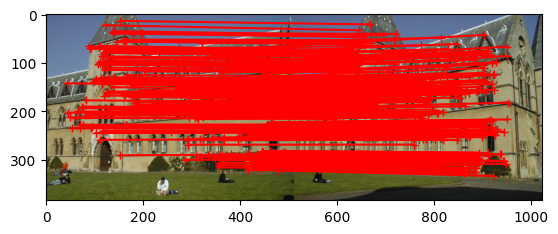

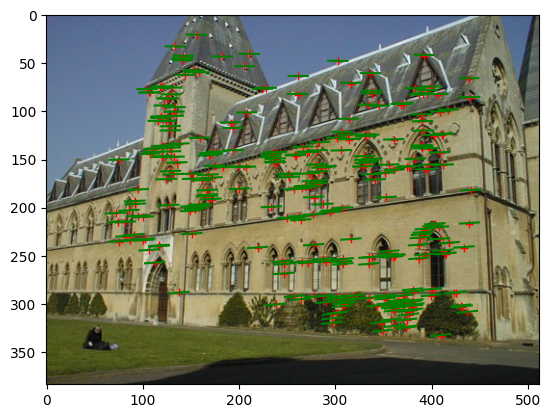

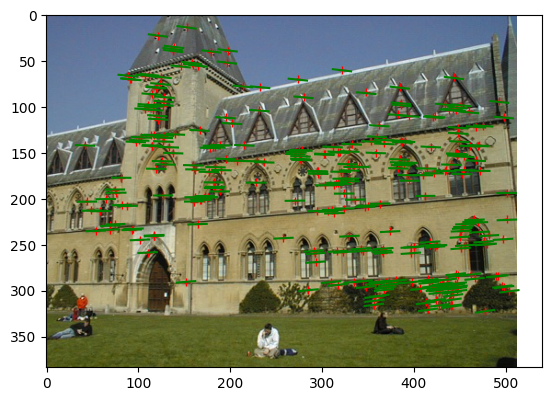

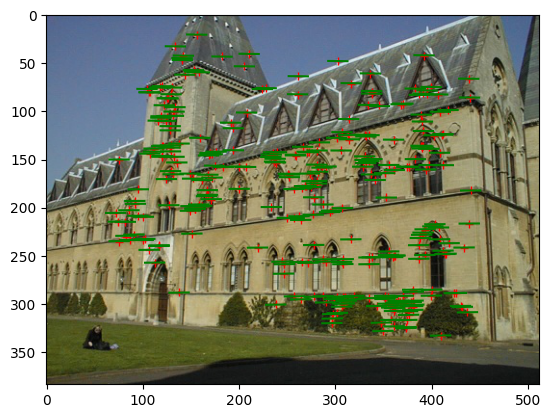

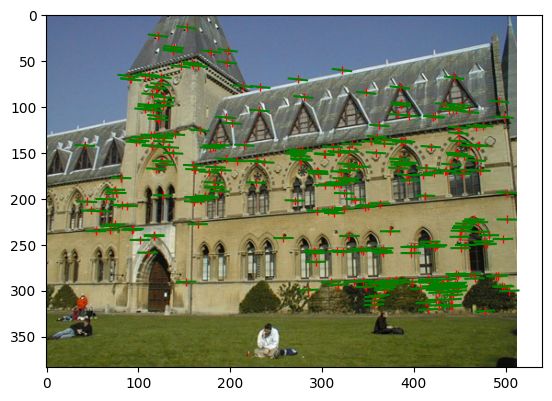

In [100]:
# Fundamental matrix estimation
name = 'library' 
# You also need to report results for name = 'lab'
# name = 'lab'

I1 = Image.open('./{:s}1.jpg'.format(name))
I2 = Image.open('./{:s}2.jpg'.format(name))
matches = np.loadtxt('./{:s}_matches.txt'.format(name))
N = len(matches);

## Display two images side-by-side with matches
## this code is to help you visualize the matches, you don't need
## to use it to produce the results for the assignment
I3 = np.zeros((I1.size[1],I1.size[0]*2,3))
I3[:,:I1.size[0],:] = I1;
I3[:,I1.size[0]:,:] = I2;
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.plot(matches[:,0],matches[:,1],  '+r')
ax.plot( matches[:,2]+I1.size[0],matches[:,3], '+r')
ax.plot([matches[:,0], matches[:,2]+I1.size[0]],[matches[:,1], matches[:,3]], 'r')
ax.imshow(np.array(I3).astype(np.uint8))

# non-normalized method
F = fit_fundamental(matches) # <YOUR CODE>
print(F)
pt1_2d = matches[:, :2]
pt2_2d = matches[:, 2:]
v2 = get_residual(F, pt1_2d, pt2_2d)
v1 = get_residual(F.T, pt2_2d, pt1_2d)
print('{:s}: residual in frame 2 (non-normalized method) = '.format(name), v2)
print('{:s}: residual in frame 1 (non-normalized method) = '.format(name), v1)
print('{:s}: residual combined   (non-normalized method) = '.format(name), (v1+v2)/2)
# Plot epipolar lines in image I2
fig, ax = plt.subplots()
plot_fundamental(ax, F, pt1_2d, pt2_2d, I2)
fig.savefig('unnormalized_I2.png')
# Plot epipolar lines in image I1
fig, ax = plt.subplots()
plot_fundamental(ax, F.T, pt2_2d, pt1_2d, I1)
fig.savefig('unnormalized_I1.png')

# normalized method
F = fit_fundamental_normalized(matches) # <YOUR CODE>
print(F)
pt1_2d = matches[:, :2]
pt2_2d = matches[:, 2:]
v2 = get_residual(F, pt1_2d, pt2_2d)
v1 = get_residual(F.T, pt2_2d, pt1_2d)
print('{:s}: residual in frame 2 (normalized method) = '.format(name), v2)
print('{:s}: residual in frame 1 (normalized method) = '.format(name), v1)
print('{:s}: residual combined   (normalized method) = '.format(name), (v1+v2)/2)
# Plot epipolar lines in image I2
fig, ax = plt.subplots()
plot_fundamental(ax, F, pt1_2d, pt2_2d, I2)
fig.savefig('normalized_I2.png')
# Plot epipolar lines in image I1
fig, ax = plt.subplots()
plot_fundamental(ax, F.T, pt2_2d, pt1_2d, I1)
fig.savefig('normalized_I1.png')

[[-5.36264198e-07  7.90364771e-06 -1.88600204e-03]
 [ 8.83539184e-06  1.21321685e-06  1.72332901e-02]
 [-9.07382264e-04 -2.64234650e-02  9.99500092e-01]]
lab: residual in frame 2 (non-normalized method) =  6.567091502178205
lab: residual in frame 1 (non-normalized method) =  9.760655424957395
lab: residual combined   (non-normalized method) =  8.1638734635678
[[-1.17248591e-07  1.60824663e-06 -4.01980786e-04]
 [ 1.11212887e-06 -2.73443755e-07  3.23319884e-03]
 [-2.36400817e-05 -4.44404958e-03  1.03455561e-01]]
lab: residual in frame 2 (normalized method) =  0.5473984648841871
lab: residual in frame 1 (normalized method) =  0.5792257462301152
lab: residual combined   (normalized method) =  0.5633121055571512


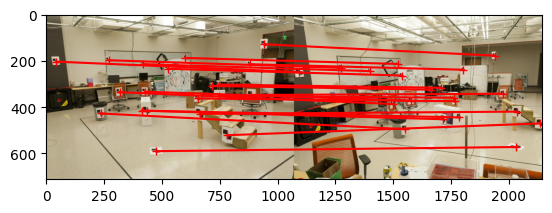

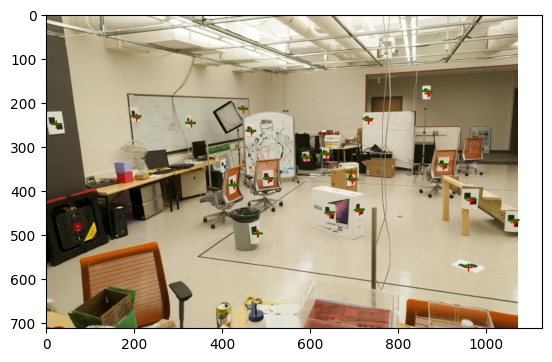

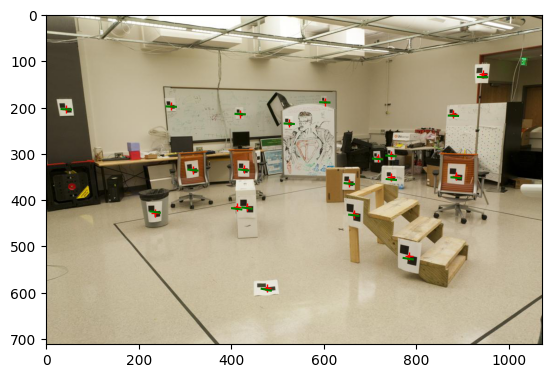

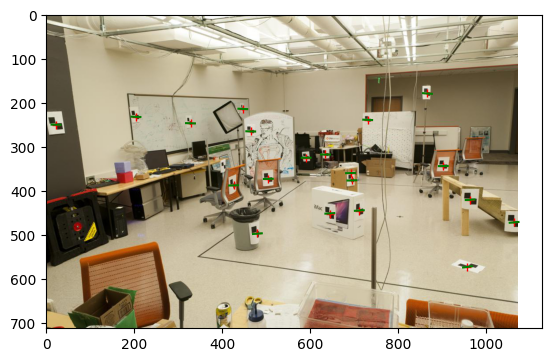

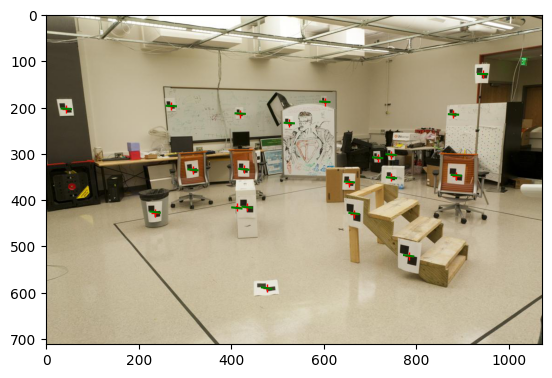

In [101]:
# Fundamental matrix estimation
name = 'lab'

I1 = Image.open('./{:s}1.jpg'.format(name))
I2 = Image.open('./{:s}2.jpg'.format(name))
matches = np.loadtxt('./{:s}_matches.txt'.format(name))
N = len(matches);

## Display two images side-by-side with matches
## this code is to help you visualize the matches, you don't need
## to use it to produce the results for the assignment
I3 = np.zeros((I1.size[1],I1.size[0]*2,3))
I3[:,:I1.size[0],:] = I1;
I3[:,I1.size[0]:,:] = I2;
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.plot(matches[:,0],matches[:,1],  '+r')
ax.plot( matches[:,2]+I1.size[0],matches[:,3], '+r')
ax.plot([matches[:,0], matches[:,2]+I1.size[0]],[matches[:,1], matches[:,3]], 'r')
ax.imshow(np.array(I3).astype(np.uint8))
fig.savefig('lab_vis.png')

# non-normalized method
F = fit_fundamental(matches) # <YOUR CODE>
print(F)
pt1_2d = matches[:, :2]
pt2_2d = matches[:, 2:]
v2 = get_residual(F, pt1_2d, pt2_2d)
v1 = get_residual(F.T, pt2_2d, pt1_2d)
print('{:s}: residual in frame 2 (non-normalized method) = '.format(name), v2)
print('{:s}: residual in frame 1 (non-normalized method) = '.format(name), v1)
print('{:s}: residual combined   (non-normalized method) = '.format(name), (v1+v2)/2)
# Plot epipolar lines in image I2
fig, ax = plt.subplots()
plot_fundamental(ax, F, pt1_2d, pt2_2d, I2)
fig.savefig('unnormalized_lab_I2.png')
# Plot epipolar lines in image I1
fig, ax = plt.subplots()
plot_fundamental(ax, F.T, pt2_2d, pt1_2d, I1)
fig.savefig('unnormalized_lab_I1.png')

# normalized method
F = fit_fundamental_normalized(matches) # <YOUR CODE>
print(F)
pt1_2d = matches[:, :2]
pt2_2d = matches[:, 2:]
v2 = get_residual(F, pt1_2d, pt2_2d)
v1 = get_residual(F.T, pt2_2d, pt1_2d)
print('{:s}: residual in frame 2 (normalized method) = '.format(name), v2)
print('{:s}: residual in frame 1 (normalized method) = '.format(name), v1)
print('{:s}: residual combined   (normalized method) = '.format(name), (v1+v2)/2)
# Plot epipolar lines in image I2
fig, ax = plt.subplots()
plot_fundamental(ax, F, pt1_2d, pt2_2d, I2)
fig.savefig('normalized_lab_I2.png')
# Plot epipolar lines in image I1
fig, ax = plt.subplots()
plot_fundamental(ax, F.T, pt2_2d, pt1_2d, I1)
fig.savefig('normalized_lab_I1.png')

#### Part (2)

In [102]:
def evaluate_points(M, points_2d, points_3d):
    """
    Visualize the actual 2D points and the projected 2D points calculated from
    the projection matrix
    You do not need to modify anything in this function, although you can if you
    want to
    :param M: projection matrix 3 x 4
    :param points_2d: 2D points N x 2
    :param points_3d: 3D points N x 3
    :return:
    """
    N = len(points_3d)
    points_3d = np.hstack((points_3d, np.ones((N, 1))))
    points_3d_proj = np.dot(M, points_3d.T).T
    u = points_3d_proj[:, 0] / points_3d_proj[:, 2]
    v = points_3d_proj[:, 1] / points_3d_proj[:, 2]
    residual = np.sum(np.hypot(u-points_2d[:, 0], v-points_2d[:, 1]))
    points_3d_proj = np.hstack((u[:, np.newaxis], v[:, np.newaxis]))
    return points_3d_proj, residual

# Write your code here for camera calibration (lab)
def camera_calibration(points, projection):
    """
    write your code to compute camera matrix
    """
    # <YOUR CODE>
    # Convert 3D-2D correspondences to homogeneous coordinates
    points_hom = np.hstack([points[:, :3], np.ones((points.shape[0], 1))])
    projection_hom = np.hstack([projection, np.ones((projection.shape[0], 1))])

    # Construct the matrix A
    A = []
    for i in range(points.shape[0]):
        X, Y, Z = points_hom[i, :3]
        u, v, w = projection_hom[i, :]
        A.append([X, Y, Z, 1, 0, 0, 0, 0, -u*X, -u*Y, -u*Z, -u])
        A.append([0, 0, 0, 0, X, Y, Z, 1, -v*X, -v*Y, -v*Z, -v])
    A = np.asarray(A)

    # Solve the homogeneous system of linear equations using SVD
    _, _, Vh = np.linalg.svd(A)
    P = Vh[-1, :].reshape(3, 4)
    return P


# Load 3D points, and their corresponding locations in 
# the two images.
pts_3d = np.loadtxt('./lab_3d.txt')
matches = np.loadtxt('./lab_matches.txt')

# <YOUR CODE> print lab camera projection matrices:
lab1_proj = camera_calibration(pts_3d, matches[:, :2])
lab2_proj = camera_calibration(pts_3d, matches[:, 2:])
print('lab 1 camera projection')
print(lab1_proj)

print('')
print('lab 2 camera projection')
print(lab2_proj)

# <YOUR CODE> evaluate the residuals for both estimated cameras
_, lab1_res = evaluate_points(lab1_proj, matches[:, :2], pts_3d)
print('residuals between the observed 2D points and the projected 3D points:')
print('residual in lab1:', lab1_res)
_, lab2_res = evaluate_points(lab2_proj, matches[:, 2:], pts_3d)
print('residual in lab2:', lab2_res)

lab 1 camera projection
[[ 3.09963996e-03  1.46204548e-04 -4.48497465e-04 -9.78930678e-01]
 [ 3.07018252e-04  6.37193664e-04 -2.77356178e-03 -2.04144405e-01]
 [ 1.67933533e-06  2.74767684e-06 -6.83964827e-07 -1.32882928e-03]]

lab 2 camera projection
[[ 6.93154686e-03 -4.01684470e-03 -1.32602928e-03 -8.26700554e-01]
 [ 1.54768732e-03  1.02452760e-03 -7.27440714e-03 -5.62523256e-01]
 [ 7.60946050e-06  3.70953989e-06 -1.90203244e-06 -3.38807712e-03]]
residuals between the observed 2D points and the projected 3D points:
residual in lab1: 13.54583290508715
residual in lab2: 15.544953435941322


In [103]:
lib1_proj = np.loadtxt('./library1_camera.txt')
lib2_proj = np.loadtxt('./library2_camera.txt')
print('library1 camera projection')
print(lib1_proj)
print('library2 camera projection')
print(lib2_proj)

library1 camera projection
[[-4.5250208e+01  4.8215478e+02  4.0948922e+02  3.4440464e+03]
 [ 4.8858466e+02  2.7346374e+02 -1.3977268e+02  4.8030231e+03]
 [-1.9787463e-01  8.8042214e-01 -4.3093212e-01  2.8032556e+01]]
library2 camera projection
[[-5.9593834e+01  5.5643970e+02  2.3093716e+02  3.5683545e+03]
 [ 4.6419679e+02  2.2628430e+02 -1.9605278e+02  4.8734171e+03]
 [-1.9116708e-01  7.2057697e-01 -6.6650130e-01  2.8015392e+01]]


#### Part (3)

In [104]:
# Write your code here for computing camera centers
def calc_camera_center(P):
    """
    write your code to get camera center in the world 
    from the projection matrix
    """
    # <YOUR CODE>
    # Compute the null space of the projection matrix
    _, _, Vh = np.linalg.svd(P)
    X = Vh[-1, :4]

    # Normalize the solution to obtain homogeneous coordinates
    X = X / X[-1]

    return X[:-1]


# <YOUR CODE> compute the camera centers using 
# the projection matrices
lab1_c = calc_camera_center(lab1_proj)
lab2_c = calc_camera_center(lab2_proj)
print('lab1 camera center', lab1_c)
print('lab2 camera center', lab2_c)

# <YOUR CODE> compute the camera centers with the projection matrices
lib1_c = calc_camera_center(lib1_proj)
lib2_c = calc_camera_center(lib2_proj)
print('library1 camera center', lib1_c)
print('library2 camera center', lib2_c)

lab1 camera center [305.83276769 304.20103826  30.13699243]
lab2 camera center [303.10003925 307.18428016  30.42166874]
library1 camera center [  7.28863053 -21.52118112  17.73503585]
library2 camera center [  6.89405488 -15.39232716  23.41498687]


#### Part (4)

Mean 3D reconstuction error for the lab data:  0.00104
2D reprojection error for the lab 1 data:  10.899446002031738
2D reprojection error for the lab 2 data:  1.5485148152476724
2D reprojection error for the library 1 data:  24.662071196868382
2D reprojection error for the library 2 data:  28.64953773526143


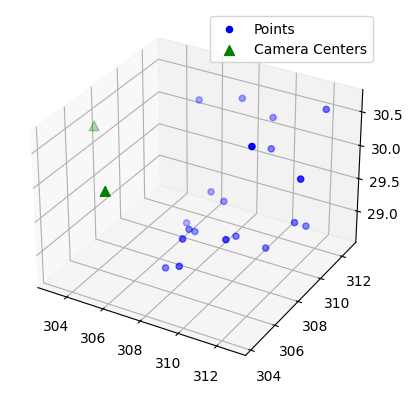

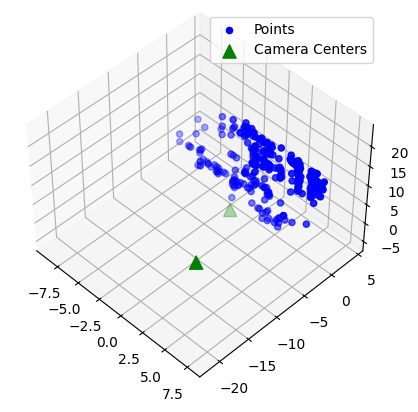

In [105]:
# Write your code here for triangulation
from mpl_toolkits.mplot3d import Axes3D
def triangulation(P1, P2, matches):
    """
    write your code to triangulate the points in 3D
    """
    # <YOUR CODE>
    N = matches.shape[0]
    X = np.zeros((N, 3))
    for i in range(N):
        x1, y1, x2, y2 = matches[i]
        A = np.array([
            [y1*P1[2, 0] - P1[1, 0], y1*P1[2, 1] - P1[1, 1], y1*P1[2, 2] - P1[1, 2], y1*P1[2, 3] - P1[1, 3]],
            [x1*P1[2, 0] - P1[0, 0], x1*P1[2, 1] - P1[0, 1], x1*P1[2, 2] - P1[0, 2], x1*P1[2, 3] - P1[0, 3]],
            [y2*P2[2, 0] - P2[1, 0], y2*P2[2, 1] - P2[1, 1], y2*P2[2, 2] - P2[1, 2], y2*P2[2, 3] - P2[1, 3]],
            [x2*P2[2, 0] - P2[0, 0], x2*P2[2, 1] - P2[0, 1], x2*P2[2, 2] - P2[0, 2], x2*P2[2, 3] - P2[0, 3]]
        ])
        U, S, V = np.linalg.svd(A)
        X[i] = V[-1, :3] / V[-1, 3]
    return X

def evaluate_points_3d(output, points_3d_gt):
    """
    write your code to evaluate the triangulated 3D points
    """
    # <YOUR CODE>
    return np.sum(output - points_3d_gt)

# triangulate the 3D point cloud for the lab data 
matches_lab = np.loadtxt('./lab_matches.txt')
points_3d_gt = np.loadtxt('./lab_3d.txt')
points_3d_lab = triangulation(lab1_proj, lab2_proj, matches_lab) # <YOUR CODE>
res_3d_lab = evaluate_points_3d(points_3d_lab, points_3d_gt) # <YOUR CODE>
print('Mean 3D reconstuction error for the lab data: ', round(np.mean(res_3d_lab), 5))
_, res_2d_lab1 = evaluate_points(lab1_proj, matches[:, :2], points_3d_lab)
_, res_2d_lab2 = evaluate_points(lab2_proj, matches[:, 2:], points_3d_lab)
print('2D reprojection error for the lab 1 data: ', np.mean(res_2d_lab1))
print('2D reprojection error for the lab 2 data: ', np.mean(res_2d_lab2))
# visualization of lab point cloud
camera_centers = np.vstack((lab1_c, lab2_c))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3d_lab[:, 0], points_3d_lab[:, 1], points_3d_lab[:, 2], c='b', label='Points')
ax.scatter(camera_centers[:, 0], camera_centers[:, 1], camera_centers[:, 2], c='g', s=50, marker='^', label='Camera Centers')
ax.legend(loc='best')
fig.savefig('triangulation1.png')

# triangulate the 3D point cloud for the library data
matches_lib = np.loadtxt('./library_matches.txt')
points_3d_lib = triangulation(lib1_proj, lib2_proj, matches_lib) # <YOUR CODE>
_, res_2d_lib1 = evaluate_points(lib1_proj, matches_lib[:, :2], points_3d_lib)
_, res_2d_lib2 = evaluate_points(lib2_proj, matches_lib[:, 2:], points_3d_lib)
print('2D reprojection error for the library 1 data: ', np.mean(res_2d_lib1))
print('2D reprojection error for the library 2 data: ', np.mean(res_2d_lib2))
# visualization of library point cloud
camera_centers_library = np.vstack((lib1_c, lib2_c))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3d_lib[:, 0], points_3d_lib[:, 1], points_3d_lib[:, 2], c='b', label='Points')
ax.scatter(camera_centers_library[:, 0], camera_centers_library[:, 1], 
           camera_centers_library[:, 2], c='g', s=90, 
           marker='^', label='Camera Centers')
ax.view_init(azim=-45, elev=45)
ax.legend(loc='best')
fig.savefig('triangulation2.png')

Extra Credit

In [106]:
def imread(fname):
    """
    read image into np array from file
    """
    return skimage.io.imread(fname)

def imread_bw(fname):
    """
    read image as gray scale format
    """
    return cv2.cvtColor(imread(fname), cv2.COLOR_BGR2GRAY)

def imshow(img):
    """
    show image
    """
    skimage.io.imshow(img)
    
def get_sift_data(img):
    """
    detect the keypoints and compute their SIFT descriptors with opencv library
    """
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(img, None)
    return kp, des

def plot_inlier_matches(ax, img1, img2, inliers):
    """
    plot the match between two image according to the matched keypoints
    :param ax: plot handle
    :param img1: left image
    :param img2: right image
    :inliers: x,y in the first image and x,y in the second image (Nx4)
    """
    res = np.hstack([img1, img2])
    ax.set_aspect('equal')
    ax.imshow(res, cmap='gray')
    
    ax.plot(inliers[:,0], inliers[:,1], '+r')
    ax.plot(inliers[:,2] + img1.shape[1], inliers[:,3], '+r')
    ax.plot([inliers[:,0], inliers[:,2] + img1.shape[1]],
            [inliers[:,1], inliers[:,3]], 'r', linewidth=0.4)
    ax.axis('off')

In [107]:
def get_best_matches(img1, img2, num_matches):
    kp1, des1 = get_sift_data(img1)
    kp2, des2 = get_sift_data(img2)
    kp1, kp2 = np.array(kp1), np.array(kp2)
    
    # Find distance between descriptors in images
    dist = scipy.spatial.distance.cdist(des1, des2, 'sqeuclidean')
    
    # Write your code to get the matches according to dist
    # <YOUR CODE>
    # Create a list of matches
    matches = np.zeros((num_matches, 4))
    indices = np.argpartition(dist.ravel(), num_matches)[:num_matches]
    rows, cols = np.unravel_index(indices, dist.shape)
    idx=0
    for i,j in zip(rows, cols):
      matches[idx, :] =np.array([*kp1[i].pt, *kp2[j].pt])
      idx+=1  
    return matches

def ransac(matches, distance_threshold=2, outlier_ratio=0.2):
    """
    write your ransac code to find the best model, inliers, and residuals
    """
    p = 0.99
    s = 8
    e = outlier_ratio
    N = int(np.log(1 - p)/np.log(1 - (1 - e)**s))
    threshold = distance_threshold
    best_homography=None
    min_residual = np.inf
    for i in range(N):
        sample = matches[np.random.choice(matches.shape[0], s, replace=False)]
        F = fit_fundamental_normalized(sample).reshape(3, 3)
        residual = (get_residual(F, matches[:, :2], matches[:, 2:]) + get_residual(F.T, matches[:, 2:], matches[:, :2]))/2
        outliers = matches[residual > threshold]         
        if outliers.shape[0] / matches.shape[0] < e:
            best_residual = residual[residual <= threshold]
            inliers = matches[residual <= threshold]
            best_homography = fit_fundamental_normalized(inliers).reshape(3, 3)
            return best_homography, inliers, best_residual
        inlier_residual = np.mean(residual[residual <= threshold])
        if inlier_residual < min_residual:
            min_residual = inlier_residual
            best_inliers_indices = residual <= threshold
    inliers = matches[best_inliers_indices]
    best_residual = residual[best_inliers_indices]
    best_homography = fit_fundamental_normalized(inliers).reshape(3, 3)
    return best_homography, inliers, best_residual

    

def compute_homography(matches):
    """
    write your code to compute homography according to the matches
    """
    num_correspondences = matches.shape[0]
    
    # Construct A matrix
    H_mat = np.zeros((2*num_correspondences, 9))
    for i in range(num_correspondences):
        x1,y1 =matches[i][0],matches[i][1]
        x2 = matches[i][2]
        y2 = matches[i][3]
        H_mat[2*i,:] = np.array([x1, y1, 1, 0, 0, 0, -x2 * x1, -x2 * y1, -x2])
        H_mat[2*i+1,:] = np.array([0, 0, 0, x1, y1, 1, -y2 * x1, -y2 * y1, -y2])
    H_mat = np.array(H_mat)    
    U, S, V = np.linalg.svd(H_mat)
    return V[-1, :].reshape((3, 3))

def make_coordinates(W, H):
    x = np.arange(W)
    y = np.arange(H)
    xv, yv = np.meshgrid(x, y)
    xv = xv.reshape(*xv.shape, 1)
    yv = yv.reshape(*yv.shape, 1)
    ones = xv - xv + 1.
    coordinates = np.concatenate((xv, yv, ones), axis=-1)
    return coordinates.T
 

(295, 4)


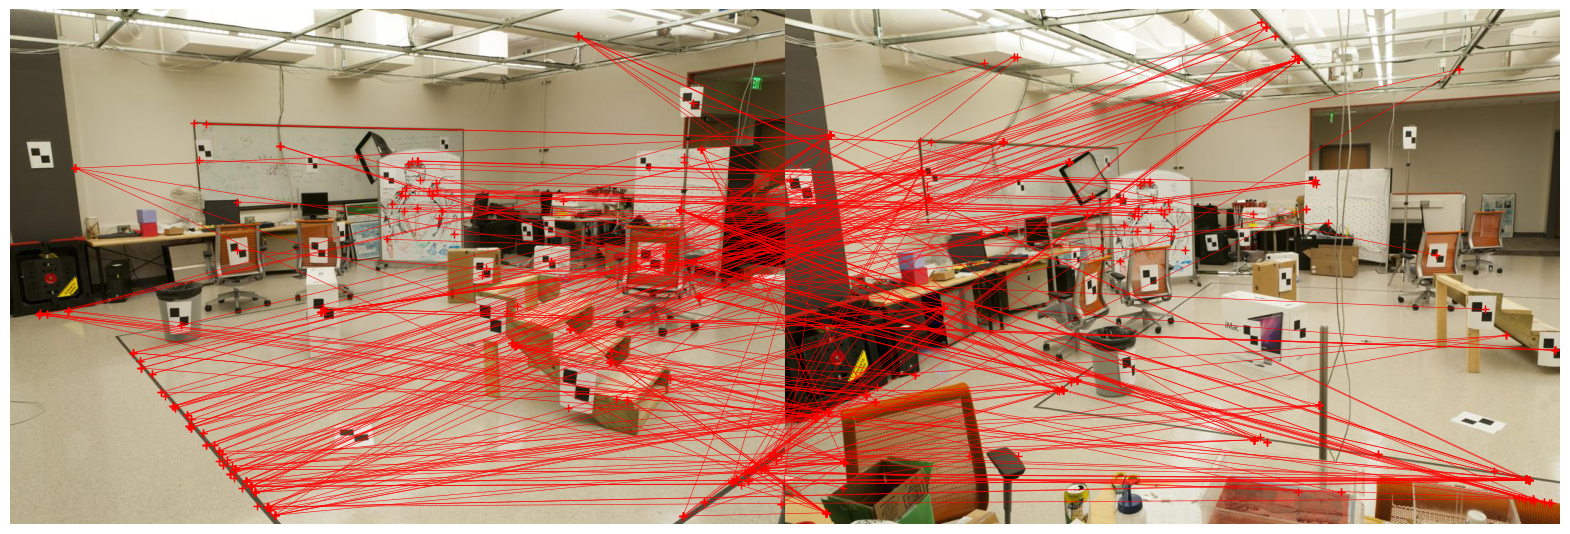

In [108]:
img1 = imread('./lab1.jpg')
img2 = imread('./lab2.jpg')

matches = get_best_matches(img1, img2, 300)
fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, img1, img2, matches)
fig.savefig('sift_match.png', bbox_inches='tight')
matches = np.unique(matches, axis=0)
print(matches.shape)

In [109]:
# display the inlier matching, report the average residual
# <YOUR CODE>
F, max_inliers, best_model_errors = ransac(matches, distance_threshold=2, outlier_ratio=0.9)
print("Average residual:", np.average(best_model_errors))
print("Inliers:", max_inliers)
fig.savefig('ransac_match_q2_lab.png', bbox_inches='tight')
print(max_inliers.shape)


<ipython-input-99-bd043d0a7f67>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  K = np.array([


ValueError: ignored